## Importing the required libraries

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
from keras import regularizers

In [4]:
import os

In [5]:
mylist= os.listdir('RawData/')

In [6]:
type(mylist)

list

In [7]:
print(mylist[1800])

03-01-08-02-02-01-02.wav


In [8]:
print(mylist[300][6:-16])

01


## Plotting the audio file's waveform and its spectrogram

In [9]:
data, sampling_rate = librosa.load('RawData/su10.wav')

Populating the interactive namespace from numpy and matplotlib


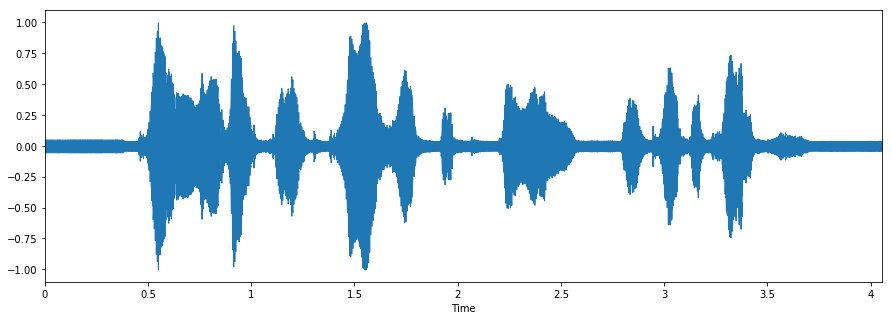

In [10]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

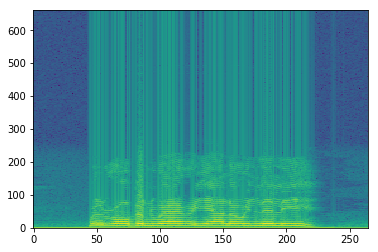

In [11]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/f10.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [12]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [13]:
labels = pd.DataFrame(feeling_list)

In [14]:
labels[:100]

,0
0,female_fearful
1,male_calm
2,male_angry
3,male_happy
4,male_sad
5,male_sad
6,male_fearful
7,male_fearful
8,male_happy
9,female_fearful


## Getting the features of audio files using librosa

In [15]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [16]:
df[:5]

,feature
0,"[-31.16371172623259, -28.617667805229384, -24...."
1,"[-78.18909734844443, -78.18909734844443, -78.1..."
2,"[-56.99171273547019, -56.94055724753519, -57.1..."
3,"[-51.82197071410353, -54.558967916818, -54.594..."
4,"[-21.45424401113206, -21.821457858201477, -22...."


In [17]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [18]:
newdf = pd.concat([df3,labels], axis=1)

In [19]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [20]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-31.163712,-28.617668,-24.917966,-24.494932,-24.846596,-25.156173,-24.030118,-25.511892,-27.973814,-31.118020,...,-36.447712,-36.467863,-36.526012,-36.526012,-36.526012,-36.526012,-36.526012,-36.526012,-36.526012,female_fearful
1,-78.189097,-78.189097,-78.189097,-78.189097,-78.189097,-73.815633,-72.413795,-73.099556,-67.491457,-68.774667,...,-58.768002,-57.641254,-56.146879,-56.331174,-56.565474,-55.813910,-56.880390,-54.337224,-53.685121,male_calm
2,-56.991713,-56.940557,-57.108037,-57.278800,-57.235216,-57.340256,-56.768300,-57.140529,-56.035926,-56.392085,...,-20.153087,-19.958597,-18.861323,-16.960626,-17.121570,-17.872438,-18.308876,-19.673627,-20.240121,male_angry
3,-51.821971,-54.558968,-54.594201,-54.274560,-54.368980,-54.870322,-55.241071,-54.999387,-55.256221,-56.148395,...,-24.167172,-25.164312,-26.231609,-25.638438,-24.241284,-24.341445,-24.899202,-21.364258,-15.935068,male_happy
4,-21.454244,-21.821458,-22.018341,-21.822263,-21.889605,-22.189542,-23.117315,-23.262418,-23.220250,-24.892574,...,-8.904398,-5.969313,-4.700791,-4.519400,-3.359315,-2.342091,-2.110662,-1.682872,-0.415320,male_sad


In [21]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
431,-24.513260,-22.167167,-17.379775,-11.275300,-8.642376,-7.940013,-10.971855,-16.131715,-19.661440,-22.238689,...,0.568834,1.094004,-1.048433,-8.315775,-12.985982,-15.235910,-18.567211,-18.440613,-16.633718,male_happy
1102,-21.902927,-23.273616,-21.924244,-22.123659,-24.271193,-23.458076,-22.998421,-21.531003,-19.574877,-17.620255,...,-16.492860,-15.750576,-13.399351,-11.390976,-9.500441,-9.373036,-8.421547,-4.663401,-2.623810,male_fearful
355,-66.133280,-66.133280,-66.133280,-66.133280,-63.475880,-63.873287,-66.124841,-66.133280,-66.133280,-66.133280,...,-39.217294,-40.929394,-43.850425,-46.328063,-45.590045,-45.385687,-48.483436,-48.762291,-50.170385,male_sad
501,-22.050646,-21.740536,-21.922631,-20.664531,-18.046473,-10.604799,-6.975279,-4.905371,-6.287567,-7.628917,...,-7.433932,-8.601229,-7.724482,-7.105503,-8.236497,-8.640867,-8.978417,-5.000906,-1.579591,male_angry
158,-63.018689,-63.018689,-63.018689,-62.108365,-61.512686,-61.152047,-60.812808,-60.676495,-60.065985,-60.582697,...,-45.491155,-45.851071,-46.737608,-47.816292,-49.592418,-51.432374,-50.115935,-49.081265,-49.202632,female_sad
630,-55.309755,-53.135627,-53.411575,-53.746281,-52.089333,-52.538318,-52.818341,-52.520157,-54.157408,-56.611049,...,-52.228938,-52.653944,-51.813917,-52.422211,-53.317482,-51.357122,-52.184839,-53.723655,-51.837224,female_calm
251,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,...,-45.666244,-45.259188,-45.147653,-45.233620,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,female_fearful
1104,-22.458639,-22.467837,-25.884357,-27.827048,-27.593531,-26.666511,-18.659022,-11.698080,-10.721751,-11.915210,...,-25.854909,-26.821354,-25.436453,-24.179943,-23.281619,-24.167497,-25.228065,-25.902942,-25.589965,male_angry
724,-46.438427,-46.438427,-46.438427,-46.438427,-46.438427,-46.438427,-46.438427,-46.438427,-46.438427,-46.438427,...,-46.438427,-46.438427,-46.438427,-46.438427,-46.438427,-46.438427,-46.438427,-46.438427,-46.438427,female_fearful
424,-53.758947,-53.771032,-53.595613,-53.295372,-53.494977,-53.358466,-53.236617,-52.074152,-52.669998,-52.826643,...,-41.439029,-39.817742,-41.279074,-43.889239,-45.182971,-44.126178,-43.821285,-46.624594,-47.807119,female_sad


In [22]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [23]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [24]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
578,-54.402685,-54.402685,-54.402685,-54.402685,-54.402685,-54.402685,-54.402685,-54.402685,-54.402685,-54.402685,...,-22.320196,-21.576941,-21.557555,-20.409180,-20.948342,-20.703416,-20.043859,-20.317258,-21.313677,male_angry
295,-43.125113,-42.607072,-42.176665,-43.992898,-44.406319,-43.787702,-43.216806,-42.295979,-43.860021,-44.955842,...,-47.686505,-46.811894,-47.146227,-47.015044,-46.772292,-47.874680,-48.482236,-48.643049,-48.773436,female_sad
1167,-26.206168,-23.347269,-22.999606,-24.832321,-24.066782,-22.414278,-22.729255,-23.514939,-25.350062,-25.353250,...,-23.564300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_sad
1145,-54.984663,-54.995117,-54.342690,-52.428592,-51.938586,-50.741923,-49.396346,-48.488101,-44.661726,-41.272555,...,-50.355849,-49.583556,-49.774373,-49.891491,-48.274491,-46.648813,-47.408262,-20.616111,-12.186651,female_happy
468,-50.881600,-52.780425,-54.581835,-55.393875,-53.599228,-52.997975,-53.848265,-51.618892,-52.170262,-53.926205,...,-41.698453,-40.541956,-40.742645,-40.039662,-40.255129,-40.493224,-41.870323,-33.741689,-27.337325,female_angry
522,-20.219598,-21.876684,-27.311933,-27.688710,-25.863421,-25.509608,-26.736341,-24.758103,-24.527573,-26.177911,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_fearful
88,-26.675596,-26.814440,-26.071193,-24.119533,-23.960812,-24.719870,-25.177376,-24.979167,-25.492311,-23.499086,...,-1.688768,-1.754933,-2.053153,-2.468604,-2.796008,-2.937894,-2.742267,-2.874263,-2.575359,male_happy
745,-54.921904,-54.603808,-56.045561,-56.816213,-56.622981,-55.934172,-55.116279,-52.974821,-54.233872,-55.541849,...,-22.480497,-22.020355,-23.458088,-22.972700,-22.354030,-23.124875,-20.957473,-20.438779,-19.000306,male_fearful
1007,-63.898264,-59.659370,-56.782403,-54.998432,-58.540780,-63.898264,-61.179316,-58.758710,-61.959276,-63.536817,...,-56.474090,-58.214918,-58.713482,-58.827720,-57.919724,-57.178619,-57.815925,-62.274446,-63.898264,male_fearful
11,-70.746514,-70.746514,-70.025286,-69.131263,-70.746514,-70.746514,-70.746514,-70.746514,-70.746514,-70.746514,...,-32.430043,-32.474731,-34.334454,-38.280955,-39.110355,-41.010279,-40.282721,-41.454053,-44.383208,male_calm


In [25]:
trainfeatures = train.iloc[:, :-1]

In [26]:
trainlabel = train.iloc[:, -1:]

In [27]:
testfeatures = test.iloc[:, :-1]

In [28]:
testlabel = test.iloc[:, -1:]

In [29]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/home/gaurab/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
X_train.shape

(952, 216)

## Changing dimension for CNN model

In [32]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [33]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_2 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)           82048     
__________

In [35]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [36]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=400, validation_data=(x_testcnn, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 952 samples, validate on 248 samples
Epoch 1/400
952/952 [==============================] - 3s 3ms/step - loss: 2.5299 - acc: 0.0872 - val_loss: 2.3294 - val_acc: 0.0887
Epoch 2/400
952/952 [==============================] - 3s 3ms/step - loss: 2.2946 - acc: 0.1261 - val_loss: 2.2910 - val_acc: 0.1210
Epoch 3/400
952/952 [==============================] - 3s 3ms/step - loss: 2.2691 - acc: 0.1408 - val_loss: 2.2753 - val_acc: 0.1331
Epoch 4/400
952/952 [==============================] - 3s 3ms/step - loss: 2.2464 - acc: 0.1649 - val_loss: 2.2540 - val_acc: 0.1371
Epoch 5/400
952/952 [==============================] - 3s 3ms/step - loss: 2.2261 - acc: 0.1702 - val_loss: 2.2439 - val_acc: 0.1774
Epoch 6/400
952/952 [==============================] - 3s 3ms/step - loss: 2.2083 - acc: 0.1849 - val_loss: 2.2259 - val_acc: 0.1613
Epoch 7/400
952/952 [==============================] - 3s 3ms/step - loss: 2.1881 - acc: 0.1891 - val_loss: 

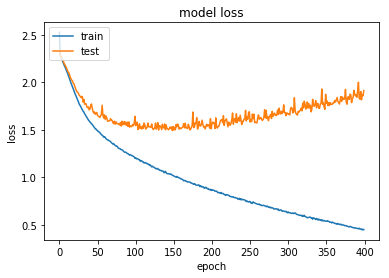

In [37]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [38]:
model_name = 'Emotion_Voice_Detection_Model_Panda.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/gaurab/Emo_classifier/Speech-Emotion-Analyzer/saved_models/Emotion_Voice_Detection_Model_Panda.h5 


In [39]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [40]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model_Panda.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 40.32%


## Predicting emotions on the test data

In [41]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

248/248 [==============================] - 0s 891us/step


In [42]:
preds

array([[3.5803299e-13, 1.3753810e-28, 1.7372361e-16, ..., 4.2578713e-03,
        2.5507802e-01, 9.8275527e-02],
       [2.5855345e-06, 1.0721478e-14, 3.8308063e-09, ..., 2.9281285e-03,
        4.6430211e-04, 4.5734970e-04],
       [7.1896205e-04, 8.5301039e-08, 3.6803872e-04, ..., 1.7611425e-01,
        1.4389139e-01, 4.8583198e-02],
       ...,
       [3.3629349e-01, 1.4476691e-01, 4.5504387e-02, ..., 3.4798775e-02,
        8.4340516e-03, 1.6583867e-02],
       [2.5037790e-03, 9.2846143e-01, 4.7538555e-04, ..., 2.9707391e-02,
        1.2983274e-02, 2.5483696e-03],
       [6.6511893e-05, 2.3437259e-07, 1.3432835e-06, ..., 4.8852903e-01,
        1.9945142e-01, 2.6084566e-01]], dtype=float32)

In [43]:
preds1=preds.argmax(axis=1)

In [44]:
preds1

array([5, 5, 5, 9, 9, 7, 9, 0, 6, 8, 3, 2, 6, 3, 0, 5, 8, 7, 0, 6, 4, 5,
       7, 5, 5, 7, 0, 2, 6, 5, 8, 7, 7, 7, 0, 6, 5, 8, 7, 7, 1, 0, 2, 5,
       9, 5, 5, 0, 4, 0, 6, 1, 3, 0, 5, 9, 5, 5, 4, 1, 7, 5, 1, 1, 5, 9,
       8, 7, 7, 5, 3, 4, 3, 1, 1, 3, 7, 7, 2, 6, 0, 9, 2, 7, 7, 7, 6, 6,
       7, 8, 6, 7, 6, 5, 0, 9, 2, 7, 7, 0, 0, 5, 7, 5, 2, 6, 3, 5, 9, 1,
       5, 8, 8, 2, 1, 8, 2, 1, 3, 3, 8, 0, 3, 9, 1, 5, 5, 0, 1, 9, 5, 5,
       1, 2, 2, 4, 2, 0, 5, 7, 5, 5, 7, 0, 6, 5, 7, 7, 5, 6, 1, 3, 7, 5,
       5, 2, 8, 5, 2, 9, 8, 7, 6, 1, 3, 8, 8, 4, 7, 3, 8, 5, 8, 8, 5, 0,
       5, 6, 4, 2, 1, 1, 8, 1, 8, 5, 5, 5, 9, 7, 5, 0, 9, 5, 0, 8, 9, 5,
       8, 5, 0, 3, 7, 5, 7, 8, 5, 6, 8, 7, 4, 5, 9, 3, 0, 6, 2, 8, 2, 3,
       3, 5, 7, 7, 2, 9, 7, 7, 9, 0, 8, 5, 6, 7, 9, 0, 4, 5, 6, 0, 3, 0,
       8, 6, 3, 4, 1, 7])

In [45]:
abc = preds1.astype(int).flatten()

In [46]:
abc

array([5, 5, 5, 9, 9, 7, 9, 0, 6, 8, 3, 2, 6, 3, 0, 5, 8, 7, 0, 6, 4, 5,
       7, 5, 5, 7, 0, 2, 6, 5, 8, 7, 7, 7, 0, 6, 5, 8, 7, 7, 1, 0, 2, 5,
       9, 5, 5, 0, 4, 0, 6, 1, 3, 0, 5, 9, 5, 5, 4, 1, 7, 5, 1, 1, 5, 9,
       8, 7, 7, 5, 3, 4, 3, 1, 1, 3, 7, 7, 2, 6, 0, 9, 2, 7, 7, 7, 6, 6,
       7, 8, 6, 7, 6, 5, 0, 9, 2, 7, 7, 0, 0, 5, 7, 5, 2, 6, 3, 5, 9, 1,
       5, 8, 8, 2, 1, 8, 2, 1, 3, 3, 8, 0, 3, 9, 1, 5, 5, 0, 1, 9, 5, 5,
       1, 2, 2, 4, 2, 0, 5, 7, 5, 5, 7, 0, 6, 5, 7, 7, 5, 6, 1, 3, 7, 5,
       5, 2, 8, 5, 2, 9, 8, 7, 6, 1, 3, 8, 8, 4, 7, 3, 8, 5, 8, 8, 5, 0,
       5, 6, 4, 2, 1, 1, 8, 1, 8, 5, 5, 5, 9, 7, 5, 0, 9, 5, 0, 8, 9, 5,
       8, 5, 0, 3, 7, 5, 7, 8, 5, 6, 8, 7, 4, 5, 9, 3, 0, 6, 2, 8, 2, 3,
       3, 5, 7, 7, 2, 9, 7, 7, 9, 0, 8, 5, 6, 7, 9, 0, 4, 5, 6, 0, 3, 0,
       8, 6, 3, 4, 1, 7])

In [47]:
predictions = (lb.inverse_transform((abc)))

In [48]:
predictions

array(['male_angry', 'male_angry', 'male_angry', 'male_sad', 'male_sad',
       'male_fearful', 'male_sad', 'female_angry', 'male_calm',
       'male_happy', 'female_happy', 'female_fearful', 'male_calm',
       'female_happy', 'female_angry', 'male_angry', 'male_happy',
       'male_fearful', 'female_angry', 'male_calm', 'female_sad',
       'male_angry', 'male_fearful', 'male_angry', 'male_angry',
       'male_fearful', 'female_angry', 'female_fearful', 'male_calm',
       'male_angry', 'male_happy', 'male_fearful', 'male_fearful',
       'male_fearful', 'female_angry', 'male_calm', 'male_angry',
       'male_happy', 'male_fearful', 'male_fearful', 'female_calm',
       'female_angry', 'female_fearful', 'male_angry', 'male_sad',
       'male_angry', 'male_angry', 'female_angry', 'female_sad',
       'female_angry', 'male_calm', 'female_calm', 'female_happy',
       'female_angry', 'male_angry', 'male_sad', 'male_angry',
       'male_angry', 'female_sad', 'female_calm', 'male_fearful'

In [49]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:240]

,predictedvalues
0,male_angry
1,male_angry
2,male_angry
3,male_sad
4,male_sad
5,male_fearful
6,male_sad
7,female_angry
8,male_calm
9,male_happy


In [50]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [51]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_angry
1,male_angry
2,male_happy
3,male_calm
4,male_sad
5,male_happy
6,male_calm
7,female_fearful
8,male_calm
9,male_angry


In [52]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [54]:
finaldf[100:110]

,actualvalues,predictedvalues
100,male_sad,female_angry
101,male_angry,male_angry
102,male_fearful,male_fearful
103,male_happy,male_angry
104,female_happy,female_fearful
105,male_sad,male_calm
106,female_happy,female_happy
107,male_calm,male_angry
108,male_calm,male_sad
109,female_happy,female_calm


In [55]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,21
female_calm,19
female_fearful,22
female_happy,21
female_sad,18
male_angry,32
male_calm,23
male_fearful,33
male_happy,26


In [56]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,26
female_calm,19
female_fearful,18
female_happy,19
female_sad,10
male_angry,51
male_calm,21
male_fearful,39
male_happy,26


In [57]:
finaldf.to_csv('Predictions_Panda.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [58]:
data, sampling_rate = librosa.load('output10.wav')

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


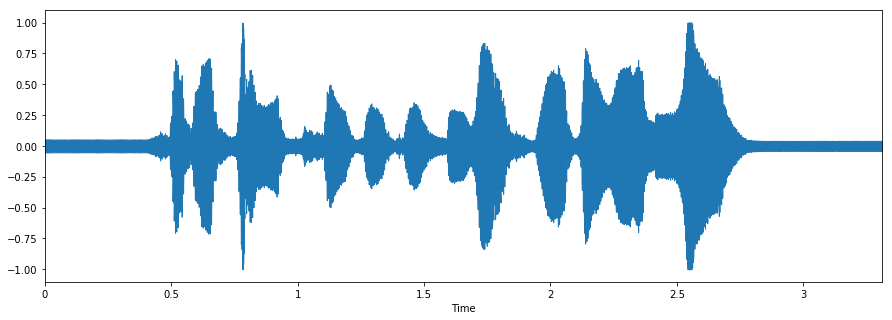

In [59]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [60]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [61]:
livedf2= pd.DataFrame(data=livedf2)

In [62]:
livedf2 = livedf2.stack().to_frame().T

In [63]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-5.18661,-6.954902,-8.514689,-8.034406,-8.01032,-8.342092,-8.884696,-8.054525,-9.238838,-10.089182,...,-24.905541,-24.886794,-23.785848,-24.147078,-24.223251,-24.390625,-25.368713,-25.882362,-24.89267,-25.33087


In [64]:
twodim= np.expand_dims(livedf2, axis=2)

In [65]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 3ms/step


In [66]:
livepreds

array([[5.1404364e-10, 1.5569200e-12, 1.5858200e-09, 3.8252725e-08,
        4.5835419e-10, 2.0845874e-01, 4.5986757e-09, 7.3938805e-01,
        3.7846934e-02, 1.4306315e-02]], dtype=float32)

In [67]:
livepreds1=livepreds.argmax(axis=1)

In [68]:
liveabc = livepreds1.astype(int).flatten()

In [69]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_fearful'], dtype=object)